The cell below contains the import statements, the variables and the parsing functions used.

### Important variables

1. **num_cpu**:  total number of cpu cores in the machine the benchmark was run on.
2. **outputfolder**: The folder which contains the output files the benchmark_run.sh script generated. 

### Important Files

1. **utilFile**: Contains the mpstat output. The seperated "@" is used to differentiate different load runs.
2. **operationsFile**: Contains the list of loads the experiment was run on.
3. **benchmarkFile**: Contains the output of the benchmark itself. 
4. **perfFile**: Contains the perf output.
5. **envFile**: Contains all the enviroment variables of the run.

### Important Functions

1. **getClientServerCPUs()**: Reads the CPU cores assigned to the server and the client using the environment variables file.
2. **readCPUUtil()**: Reads the CPU utilization of the cores assigned to the server and the client. It used the "idle_time" output of mpstat to calculate the cpu utilization. 
3. **readOperations**: Uses the operationsFile to read the different loads the experiment was run on. Here load/operations refers to the number of threads in the web-search benchmark.
4. **readPerf**: Reads the perfFile to calculate the IPC.
5. **readBenchmark**: Reads and parsed the benchmarkFile.
6. **writeCSV**: Used to generate a CSV file which contains all the relevant quantities calculated. 


In [856]:
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import xml.etree.ElementTree as ET
import csv
%matplotlib inline
num_cpu = 64 
outputfolder = "output_arm"
utilFile = outputfolder+"/util.txt"
operationsFile = outputfolder+"/operations.txt"
benchmarkFile = outputfolder+"/benchmark.txt"
perfFile = outputfolder+"/perf.txt"
envFile = outputfolder+"/env.txt
    
def writeCSV(filename,sorted_op,benchStdMean):
    ''' Writes the data to a CSV file'''
    x = []
    x.append("Operations")
    for value in sorted(benchStdMean, key=str.lower):
        x.append(value)

    y = []
    y.append(x)
    for i in range(len(sorted_op)):
        x=[]
        x.append(sorted_op[i])
        for value in sorted(benchStdMean, key=str.lower):
            x.append(benchStdMean[value][i])
        y.append(x)
    with open(filename,"w+") as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        csvWriter.writerows(y)
''' The following are the parsing modules for the different files generated '''

def getCPUsFromLine(CPULine):
    ''' Used by the '''
    serverCPU = []
    for CPUs in CPULine.split(","):
        if CPUs.isdigit():
            serverCPUCurr = [int(CPUs)]
        else:
            CPUs = CPUs.split("-")
            if not (CPUs[0].isdigit() and CPUs[1].isdigit()):
                print("ERRORERRORERROR")
            else:
                serverCPUCurr = range(int(CPUs[0]),int(CPUs[1]) + 1)
        serverCPU = serverCPU + serverCPUCurr
    return serverCPU
def getClientServerCPUs(envFile):
    clientCPU = None
    serverCPU = None
    with open(envFile) as f:
        lines = f.readlines()
        for line in lines:
            if re.search('CLIENT_CPUS', line, re.I):
                CPUs = line.replace('\n','').split('=')[1]
                clientCPU = getCPUsFromLine(CPUs)
            if re.search('SERVER_CPUS', line, re.I):
                CPUs = line.replace('\n','').split('=')[1]
                serverCPU = getCPUsFromLine(CPUs)
    return serverCPU,clientCPU


def readCPUUtil(utilFile,serverCPU,clientCPU):
    idle_times={}
    for i in range(num_cpu):
        idle_times[i]=[]
    with open(utilFile) as f:
        utilBigList = f.read().split("@")[1:]
    for utilSingle in utilBigList:
        idle_times_temp = {}
        for i in range(num_cpu):
            idle_times_temp[i]=[]
        stringNewLine = utilSingle.split('\n')[2:]
        for stringLine in stringNewLine:        
            words = stringLine.split()
            if(len(words)>=11 and words[-11].isdigit()):
                CPU = int(words[-11])
                idle = float(words[-1].rstrip('\x00'))
                idle_times_temp[CPU].append(idle)
        for i in range(num_cpu):
            idle_times[i].append(idle_times_temp[i])
    idle_times_avg = {}
    for i in range(num_cpu):
        idle_times_avg[i]=[]
        for times in idle_times[i]:
            idle_times_avg[i].append(np.mean(times))
    for cpu in idle_times_avg:
        idle_times_avg[cpu] = np.array(idle_times_avg[cpu])
    util_bench = idle_times_avg[0]*0
    util_server = idle_times_avg[0]*0
    for i in range(num_cpu):
        if i in clientCPU:
            util_bench = util_bench + idle_times_avg[i]
        elif i in serverCPU:
            util_server = util_server + idle_times_avg[i]
    util_bench = 100.0 - util_bench/len(clientCPU)
    util_server = 100.0 - util_server/(len(serverCPU))
    return {
        "CPUUtilClient":util_bench,
        "CPUUtilServer":util_server
    }

def readOperations(operationsFile):
    with open(operationsFile) as f:                                                                                                                                                                                     
        operationsStr = f.read().split('\n')[:-1]
    operations = np.array(map(int, operationsStr))
    return operations
def show(elem):
    print elem.tag
    for child in elem.findall('*'):
        show(child)
        
        
def readPerf(perfFile):
    instructionsU = []
    instructionsK = []
    cycles = []
    with open(perfFile) as f:
        lines = f.readlines()
        for line in lines:
            if re.search('instructions:u', line, re.I):
                instructionsU.append(float(line.split()[0].replace(',','')))
            if re.search('instructions:k', line, re.I):
                instructionsK.append(float(line.split()[0].replace(',','')))
            if re.search('cycles', line, re.I):
                cycles.append(float(line.split()[0].replace(',','')))
    instructionsU = np.array(instructionsU)
    instructionsK = np.array(instructionsK)
    cycles = np.array(cycles)
    ipcU = instructionsU/cycles
    ipcK = instructionsK/cycles
    ipcTotal = ipcU + ipcK
    return {
        "instructionsU":instructionsU,
        "instructionsK":instructionsK,
        "cycles":cycles,
        "ipcU":ipcU,
        "ipcK":ipcK,
        "ipcTotal":ipcTotal
    }

                
                
def readBenchmark(benchmarkFile):
    xmlList = []
    start = 0
    with open(benchmarkFile) as f:
        content = f.read()
        while(True):
            a = ( string.find(content,"<benchResults>"))
            
            b = ( string.find(content[start:],"</benchResults>")) + len("</benchResults>")

            if (a is not -1 and b is not -1):
                xmlList.append(content[a:b])
                content = content[b:]
            else:
                break
    avg = []
    p90th = []
    p99th = []
    totalOps = []
    throughput = []
    for xml in xmlList:
        benchResult = ET.fromstring(xml)
        driverSummary = benchResult.find("driverSummary")
        avg.append(float(driverSummary.find("responseTimes/operation/avg").text))
        p90th.append(float(driverSummary.find("responseTimes/operation/p90th").text.replace('>','')))
        p99th.append(float(driverSummary.find("responseTimes/operation/p99th").text.replace('>','')))
        totalOps.append(float(driverSummary.find("totalOps").text))
        throughput.append(float(driverSummary.find("metric").text))
    return {
        "avg":avg,
        "p90th":p90th,
        "p99th":p99th,
        "totalOps":totalOps,
        "throughput":throughput
    }

SyntaxError: EOL while scanning string literal (<ipython-input-856-16c81a48fba2>, line 14)

This blocks calculates the mean an standard deviation using the different values corresponding to the same load (operation). 
## Important Variables
1. **sorted_op**: Contains the list of operations (threads)  in ascending order. 
2. **benchStdMean**: It's a dictionary of the quantities we are interested in. The values in the dictionaries are arrays in the same order as sorted_op. For a quantity name "q", benchStdMean\["qMean"\] contains the mean and benchStdMean\["qStd"\] contains the standard deviation.
3. **values**: This array contains the list of dictionary keys (quantities) in benchStdMean for which the mean and Standard Deviation has to be calculated. New quantities can be added and some can be removed (in case they haven't been parsed properly). **note**: "avg" refers to Average Latency.


In [ ]:

operations = readOperations(operationsFile)
bench1 = readBenchmark(benchmarkFile)
perf1 = readPerf(perfFile)
serverCPU,clientCPU = getClientServerCPUs(envFile)
util1 = readCPUUtil(utilFile,serverCPU=serverCPU,clientCPU=clientCPU)
for x in perf1:
    bench1[x] = perf1[x]
for x in util1:
    bench1[x] = util1[x]

values = ["avg","p90th","p99th","totalOps","throughput","CPUUtilClient","CPUUtilServer","instructionsU","instructionsK","cycles","ipcU","ipcK","ipcTotal"]
min_len = None
for value in values:
    if min_len is None:
        min_len = len(bench1[value])
    if len(bench1[value]) < min_len:
        min_len = len(bench1[value])
benchStdMean = {}
for value in values:
    benchStdMean[value] = []
operations = operations[0:min_len]

unique_op={}
for i in range(len(operations)):
    if operations[i] not in unique_op:
        unique_op[operations[i]] = operations[i]
sorted_op = np.sort(unique_op.keys())
for op in sorted_op:
    ii = np.where(operations == op)[0]
    for value in values:
        benchStdMean[value].append(np.take(bench1[value],ii))
for value in values:
    benchStdMean[value+"Mean"] = []
    for x in benchStdMean[value]:
        benchStdMean[value+"Mean"].append(np.mean(x)) 
    benchStdMean[value+"Std"] = []
    for x in benchStdMean[value]:
        benchStdMean[value+"Std"].append(np.std(x)) 
for value in benchStdMean:
    benchStdMean[value]=np.array(benchStdMean[value])


## Plotting
The following cell is used to make pretty plots using the calculated quantities. They can be used as a model to make newer plots.

In [ ]:

fig = plt.figure()
(a,b) = fig.get_size_inches()
plt.figure(figsize=(a, b*4))


plt.subplot(4,1,1)
plt.errorbar(sorted_op,benchStdMean["p90thMean"],yerr = benchStdMean["p90thStd"],label="90th Percentile",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["p99thMean"],yerr = benchStdMean["p99thStd"],label="99th Percentile",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["avgMean"],yerr = benchStdMean["avgStd"],label="Avg",linestyle='None',marker=".")

plt.xlabel("Threads")
plt.ylabel("Latency (s)")
plt.legend()

plt.subplot(4,1,2)
plt.errorbar(sorted_op,benchStdMean["CPUUtilClientMean"],yerr = benchStdMean["CPUUtilClientStd"],label="client",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["CPUUtilServerMean"],yerr = benchStdMean["CPUUtilServerStd"],label="server",linestyle='None',marker=".")
plt.legend()
plt.xlabel("Threads")
plt.ylabel("CPU Util (%)")


plt.subplot(4,1,3)
plt.errorbar(sorted_op,benchStdMean["throughputMean"],yerr = benchStdMean["throughputStd"],label="Throughput",linestyle='None',marker=".")
plt.xlabel("Threads")
plt.ylabel("Throughput (op/s)")

plt.subplot(4,1,4)
plt.errorbar(sorted_op,benchStdMean["ipcUMean"],yerr = benchStdMean["ipcUStd"],label="User",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["ipcKMean"],yerr = benchStdMean["ipcKStd"],label="Kernel",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["ipcTotalMean"],yerr = benchStdMean["ipcTotalStd"],label="Total",linestyle='None',marker=".")
plt.legend()
plt.xlabel("Threads")
plt.ylabel("IPC")

plt.savefig(outputfolder + "/plot.png",bbox_inches='tight')
# plt.savefig("Web_search_result.png")
plt.show()
plt.figure(1)
plt.errorbar(sorted_op,benchStdMean["instructionsUMean"],yerr = benchStdMean["instructionsUStd"],label="User",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["instructionsKMean"],yerr = benchStdMean["instructionsKStd"],label="Kernel",linestyle='None',marker=".")
# plt.errorbar(sorted_op,benchStdMean["ipcTotalMean"],yerr = benchStdMean["ipcTotalStd"],label="Total",linestyle='None',marker=".")
plt.legend()
plt.xlabel("Threads")
plt.ylabel("Instructions")
plt.show()
plt.figure(1)
plt.errorbar(sorted_op,benchStdMean["cyclesMean"],yerr = benchStdMean["cyclesStd"],linestyle='None',marker=".")
# plt.errorbar(sorted_op,benchStdMean["ipcTotalMean"],yerr = benchStdMean["ipcTotalStd"],label="Total",linestyle='None',marker=".")
# plt.legend()
plt.xlabel("Threads")
plt.ylabel("Cycles")
plt.show()

writeCSV(outputfolder+"/summary.csv",sorted_op,benchStdMean)

## Do not proceed:
The following are the dead remnants of various other scripts mostly used for specific plots. Enter at your own risk.

In [840]:
# plt.figure()
# plt.errorbar(benchStdMean["throughputMean"],benchStdMean["p99thMean"],yerr = benchStdMean["p99thStd"],xerr=benchStdMean["throughputStd"] ,label="99th Percentile",linestyle='None',marker=".")
# plt.errorbar(benchStdMean["throughputMean"],benchStdMean["avgMean"],yerr = benchStdMean["avgStd"],xerr=benchStdMean["throughputStd"] ,label="Average",linestyle='None',marker=".")
# plt.legend()
# plt.xlabel("Throughput (op/s)")
# plt.ylabel("Latency (s)")
# plt.show()

In [841]:
# plt.figure()
# plt.errorbar(benchStdMean_x86["throughputMean"],benchStdMean_x86["p99thMean"],yerr = benchStdMean_x86["p99thStd"],xerr=benchStdMean_x86["throughputStd"] ,label="99th Percentile_x86",linestyle='None',marker=".")
# plt.errorbar(benchStdMean_x86["throughputMean"],benchStdMean_x86["avgMean"],yerr = benchStdMean_x86["avgStd"],xerr=benchStdMean_x86["throughputStd"] ,label="Average_x86",linestyle='None',marker=".")
# plt.errorbar(benchStdMean_arm["throughputMean"],benchStdMean_arm["p99thMean"],yerr = benchStdMean_arm["p99thStd"],xerr=benchStdMean_arm["throughputStd"] ,label="99th Percentile_ARM",linestyle='None',marker=".")
# plt.errorbar(benchStdMean_arm["throughputMean"],benchStdMean_arm["avgMean"],yerr = benchStdMean_arm["avgStd"],xerr=benchStdMean_arm["throughputStd"] ,label="Average_ARM",linestyle='None',marker=".")
# plt.ylim(ymax=0.8)
# plt.legend()
# plt.xlabel("Throughput (op/s)")
# plt.ylabel("Latency (s)")
# plt.savefig("arm_vs_x86_latency_8cores_800ms.png")
# plt.show()

In [842]:
# print(sorted_op)
# for op in sorted_op:
#     print("{}:{}".format(op,np.count_nonzero(operations == op)))
# for i in range(len(sorted_op)):
#     print(sorted_op[i])
#     print(benchStdMean["p99th"][i])

[ 10  30  50  70  90 110 130 150 170 190 210 230 250 270 290 310 330 350]
10:6
30:6
50:6
70:5
90:5
110:6
130:6
150:6
170:6
190:5
210:6
230:6
250:5
270:5
290:6
310:6
330:6
350:6
10
[ 0.223  0.145  0.175  0.163  0.15   0.215]
30
[ 0.185  0.18   0.173  0.22   0.19   0.18 ]
50
[ 0.163  0.203  0.198  0.198  0.173  0.218]
70
[ 0.175  0.178  0.198  0.21   0.185]
90
[ 0.185  0.19   0.18   0.195  0.215]
110
[ 0.185  0.175  0.215  0.198  0.198  0.208]
130
[ 0.198  0.22   0.21   0.205  0.2    0.188]
150
[ 0.215  0.203  0.183  0.208  0.193  0.175]
170
[ 0.205  0.198  0.195  0.208  0.193  0.203]
190
[ 0.198  0.193  0.19   0.19   0.21 ]
210
[ 0.263  0.198  0.195  0.205  0.208  0.195]
230
[ 0.25   0.22   0.223  0.205  0.255  0.208]
250
[ 0.23   0.213  0.205  0.195  0.223]
270
[ 0.238  0.253  0.218  0.215  0.308]
290
[ 0.235  0.265  0.228  0.24   0.25   0.265]
310
[ 0.423  0.423  0.445  0.26   0.248  0.275]
330
[ 0.383  0.428  0.598  0.69   0.67   0.345]
350
[ 0.728  0.95   0.695  1.05   1.15   0.9  ]

In [843]:
operations

array([150, 210, 270,  50, 310, 130, 350,  10, 250, 290, 190, 230, 330,
        90, 170,  30,  70, 110, 150, 190,  90,  30, 310,  70,  50,  10,
       230, 210, 130, 330, 350, 270, 110, 290, 170, 250,  30,  10, 210,
        70, 230, 110, 350, 270, 290, 330, 310, 190, 150, 130, 250, 170,
        90,  50,  30, 330,  90, 290, 170,  10, 250, 190, 230, 110, 270,
       310,  70,  50, 350, 150, 210, 130, 290, 230,  10, 170, 330, 350,
       250,  90, 190, 270, 210,  30, 310, 110, 130,  70,  50, 150, 130,
       350, 150, 210, 230,  10, 290, 110, 310,  50,  30, 330, 170])

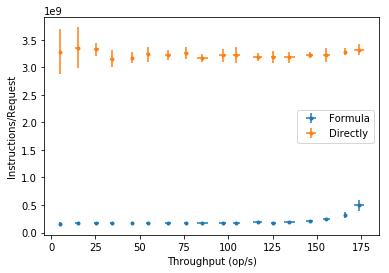

In [844]:
x = np.array([])
ins_per_req_calc_mean = []
ins_per_req_act_mean = []
ins_per_req_calc_std = []
ins_per_req_act_std = []
for i in range(len(sorted_op)):
    ins_per_req_calc = benchStdMean["avg"][i]*benchStdMean["ipcTotal"][i]*2.5*1000000000
    ins_per_req_act = (benchStdMean["instructionsU"][i]+benchStdMean["instructionsK"][i])/benchStdMean["throughput"][i]
    ins_per_req_calc_mean.append(np.mean(ins_per_req_calc))
    ins_per_req_calc_std.append(np.std(ins_per_req_calc))
    ins_per_req_act_mean.append(np.mean(ins_per_req_act))
    ins_per_req_act_std.append(np.std(ins_per_req_act))

plt.figure()
plt.errorbar(benchStdMean["throughputMean"],ins_per_req_calc_mean,xerr = benchStdMean["throughputStd"],yerr = ins_per_req_calc_std,linestyle='None',marker=".",label="Formula")
plt.errorbar(benchStdMean["throughputMean"],ins_per_req_act_mean,xerr = benchStdMean["throughputStd"],yerr = ins_per_req_act_std,linestyle='None',marker=".",label="Directly")
plt.ylabel("Instructions/Request")
plt.xlabel("Throughput (op/s)")
plt.savefig(outputfolder + "software_instructions.png")
# plt.errorbar(sorted_op,l_mean,yerr = l_std,linestyle='None',marker=".")
plt.savefig("arm.png")
plt.legend()
plt.show()



In [845]:
# ins_per_req_calc_mean_x86 = ins_per_req_calc_mean
# ins_per_req_act_mean_x86 =  ins_per_req_act_mean
# ins_per_req_calc_std_x86 =  ins_per_req_calc_std
# ins_per_req_act_std_x86 =  ins_per_req_act_std
# benchStdMean_x86 = benchStdMean
# ins_per_req_calc_mean_arm = ins_per_req_calc_mean
# ins_per_req_act_mean_arm =  ins_per_req_act_mean
# ins_per_req_calc_std_arm =  ins_per_req_calc_std
# ins_per_req_act_std_arm =  ins_per_req_act_std
# benchStdMean_arm = benchStdMean

In [846]:
np.array(ins_per_req_calc_mean)/np.array(ins_per_req_act_mean)

array([ 0.048732  ,  0.04897285,  0.05021663,  0.05181893,  0.05187657,
        0.05138053,  0.05237596,  0.05109448,  0.0537597 ,  0.05190813,
        0.05388519,  0.05741521,  0.05576538,  0.06056213,  0.06318151,
        0.07442495,  0.09653364,  0.14830234])

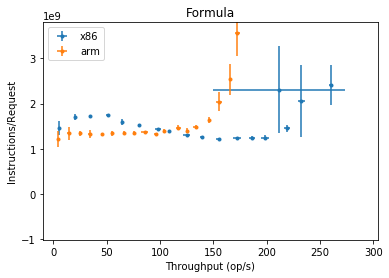

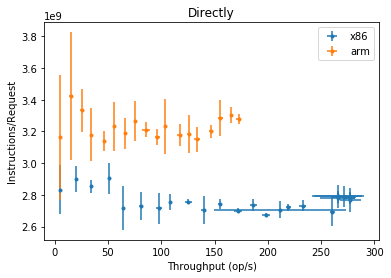

In [855]:
ins_per_req_calc_mean_x86 = np.array(ins_per_req_calc_mean_x86)
ins_per_req_calc_mean_arm = np.array(ins_per_req_calc_mean_arm)
ins_per_req_calc_std_x86 = np.array(ins_per_req_calc_std_x86)
ins_per_req_calc_std_arm = np.array(ins_per_req_calc_std_arm)
plt.figure()
plt.errorbar(benchStdMean_x86["throughputMean"],ins_per_req_calc_mean_x86*8,xerr = benchStdMean_x86["throughputStd"],yerr = ins_per_req_calc_std_x86*8,linestyle='None',marker=".",label="x86")
plt.errorbar(benchStdMean_arm["throughputMean"],ins_per_req_calc_mean_arm*8,xerr = benchStdMean_arm["throughputStd"],yerr = ins_per_req_calc_std_arm*8,linestyle='None',marker=".",label="arm")
plt.ylabel("Instructions/Request")
plt.xlabel("Throughput (op/s)")
plt.legend()
plt.ylim(ymax=3.8e9)
plt.title("Formula")
plt.savefig("formula.png")
plt.show()
# plt.plot()
plt.figure()
plt.errorbar(benchStdMean_x86["throughputMean"],ins_per_req_act_mean_x86,xerr = benchStdMean_x86["throughputStd"],yerr = ins_per_req_act_std_x86,linestyle='None',marker=".",label="x86")
plt.errorbar(benchStdMean_arm["throughputMean"],ins_per_req_act_mean_arm,xerr = benchStdMean_arm["throughputStd"],yerr = ins_per_req_act_std_arm,linestyle='None',marker=".",label="arm")
plt.ylabel("Instructions/Request")
plt.xlabel("Throughput (op/s)")
plt.legend()
plt.title("Directly")
plt.savefig("direct.png")
# plt.ylim(ymax=1e9)
plt.show()

In [836]:
# print(sorted_op_arm)
print(benchStdMean_x86["p99thMean"])

[ 0.17933333  0.1845      0.1835      0.18925     0.182       0.1735
  0.1695      0.1705      0.1535      0.1585      0.15375     0.16133333
  0.16475     0.1675      0.229       0.44933333  0.43525     0.4115      1.097
  2.08125     2.44375     2.475       2.475       2.475     ]
